In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
from torch import nn
from torch.autograd import grad

from torch_fftconv import fft_conv1d, FFTConv1d
import numpy as np
from copy import deepcopy

class simpleNet(nn.Module):
    def __init__(self):

        super(simpleNet, self).__init__()
        self.conv = nn.Conv1d(4,  10, kernel_size=51, padding=25)
        self.conv_inr = nn.Conv1d(4,  10, kernel_size=15, padding=7)
        self.conv_sim = nn.Conv1d(4,  32, kernel_size=3, padding=1)

        self.activation = nn.Softplus()
        self.softplus = nn.Softplus()

        self.deconv = FFTConv1d(10*2,  10, kernel_size=601, padding=300)
        self.deconv_sim = FFTConv1d(64,  10, kernel_size=601, padding=300)
        self.deconv_inr = nn.ConvTranspose1d(20,  10, kernel_size=15, padding=7)

        self.scaler = nn.Parameter(torch.ones(1))
        self.scaler2 = nn.Parameter(torch.ones(1))

    def forward(self, x):
        y = torch.cat([self.conv(x), self.conv(x.flip([1,2])).flip([2])], 1)
        y_sim = torch.cat([self.conv_sim(x), self.conv_sim(x.flip([1,2])).flip([2])], 1)
        y_inr = torch.cat([self.conv_inr(x), self.conv_inr(x.flip([1,2])).flip([2])], 1)


        yact = self.activation(y )
        y_sim_act = self.activation(y_sim) 
        y_inr_act = self.activation(y_inr)

        y_pred = self.softplus(self.deconv(yact)+self.deconv_inr(y_inr_act)+self.deconv_sim(y_sim_act))
        return y_pred

net = simpleNet()
net.load_state_dict(torch.load('./resources/puffin_D.pth'))
net.cuda()


simpleNet(
  (conv): Conv1d(4, 10, kernel_size=(51,), stride=(1,), padding=(25,))
  (conv_inr): Conv1d(4, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv_sim): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (activation): Softplus(beta=1, threshold=20)
  (softplus): Softplus(beta=1, threshold=20)
  (deconv): FFTConv1d(20, 10, kernel_size=(601,), stride=(1,), padding=(300,))
  (deconv_sim): FFTConv1d(64, 10, kernel_size=(601,), stride=(1,), padding=(300,))
  (deconv_inr): ConvTranspose1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
)

In [ ]:
import pandas as pd
import selene_sdk

tsses  = pd.read_table('./resources/FANTOM_CAT.lv3_robust.tss.sortedby_fantomcage.hg38.v5.tsv', sep='\t')
tsses_hc  = pd.read_table('./resources/FANTOM_CAT.lv3_robust.tss.sortedby_fantomcage.hg38.v5.highconf.tsv', sep='\t')
genome = selene_sdk.sequences.Genome(
                    input_path='./resources/Homo_sapiens.GRCh38.dna.primary_assembly.fa',
                )

In [ ]:
from Bio import Phylo
tree = Phylo.read("./resources/241-mammalian-2020v2.phast-242.nh", "newick")
species = [s.name for s in tree.get_terminals()]

import os
import uuid
from collections import defaultdict
from Bio import AlignIO, Phylo
from Bio.Seq import Seq
import pandas as pd

alignnames_anno = pd.read_csv('./resources/alignment_tree_names_mapping.csv').iloc[:,1:]
alignname_dict = {}
for i in range(alignnames_anno.shape[0]):
    alignname_dict[alignnames_anno['alignment_names'].values[i].lower()] = alignnames_anno['tree_names'].values[i].lower()
#two corrections
alignname_dict['pteale1']='Pteropus_alecto'
alignname_dict['ptepar1']='Pteronotus_parnellii'


alignname_dict['hg38'] = 'Homo_sapiens'
for key in alignname_dict:
    alignname_dict[key] = alignname_dict[key].capitalize()
    
species_anno = pd.read_table('./resources/species_anno.tsv')

species_acc = {}
for a, b in zip(species_anno['Species'], species_anno['Accession']):
    species_acc[a] = b
species_acc['Alouatta palliata'] = species_acc['Alouatta palliata mexicana']
species_acc['Tupaia chinensis'] = species_acc['Tupaia belangeri chinensis']
species_acc['Perognathus longimembris'] = species_acc['Perognathus longimembris pacificus']
species_acc['Platanista gangetica'] = species_acc['Platanista gangetica minor']
species_acc['Ovis canadensis'] = species_acc['Ovis canadensis cremnobates']
species_acc['Saiga tatarica'] = species_acc['Saiga tatarica tatarica']
species_acc['Canis lupus'] = species_acc['Canis lupus familiaris']


#load sequence name aliases
alias_dicts = {}
data = pd.read_csv('./resources/aliases/cebCap1.chromAlias.txt','\t')
alias = {}
for a, b in zip(data.values[:,0],data.values[:,1]):
    alias[a]=b
alias_dicts['cebCap1'] =  alias
    
data = pd.read_csv('./resources/aliases/colAng1.chromAlias.txt','\t')
alias = {}
for a, b in zip(data.values[:,0],data.values[:,1]):
    alias[a]=b
alias_dicts['colAng1'] =  alias

data = pd.read_csv('./resources/aliases/GCA_004026905.1.chromAlias.txt','\t')
alias = {}
for a, b in zip(data.values[:,1],data.values[:,3]):
    alias[a]=b
alias_dicts['Hystrix_cristata'] =  alias


data = pd.read_csv('./resources/aliases/nomLeu3.chromAlias.txt','\t')
alias = {}
for a, b in zip(data.values[:,0],data.values[:,2]):
    alias[a]=b
alias_dicts['nomLeu3'] =  alias

data = pd.read_csv('./resources/aliases/orcOrc1.chromAlias.txt','\t')
alias = {}
for a, b in zip(data.values[:,0],data.values[:,2]):
    alias[a]=b
alias_dicts['orcOrc1'] =  alias


data = pd.read_csv('./resources/aliases/micOch1.chromAlias.txt','\t')
alias = {}
for a, b in zip(data.index,data.values[:,1]):
    alias[a]=b
alias_dicts['micOch1'] =  alias

species_dict = {}
for i in range(species_anno.shape[0]):
    species_dict[species_anno['Species'].values[i]] = [species_anno['Common Name'].values[i], \
                                                               species_anno['Order'].values[i], \
                                                              species_anno['Family'].values[i]]
    
species_dict['Alouatta palliata'] = species_dict['Alouatta palliata mexicana']
species_dict['Tupaia chinensis'] = species_dict['Tupaia belangeri chinensis']
species_dict['Perognathus longimembris'] = species_dict['Perognathus longimembris pacificus']
species_dict['Platanista gangetica'] = species_dict['Platanista gangetica minor']
species_dict['Ovis canadensis'] = species_dict['Ovis canadensis cremnobates']
species_dict['Saiga tatarica'] = species_dict['Saiga tatarica tatarica']
species_dict['Canis lupus'] = species_dict['Canis lupus familiaris']
species_dict['Loxodonta africana'] = species_dict['Loxodonta Africana'] 


/home2/s190483/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
import h5py
with h5py.File('./data/evo_multipreds.h5', 'w') as f:
    dset = f.create_dataset("data", (40000,241,10,1000), 'f')
    for i in range(40000):
        print(i)
        multipred = np.zeros((len(species),10,1000)) * np.nan
        seqs = torch.load('./resources/evo/tss_'+str(tsses.iloc[:,0].values[i])+'_1650bp.pth')[0]

        for k in seqs.keys():    
            pred = net(torch.FloatTensor(genome.sequence_to_encoding(seqs[k][0].upper()).T[None,:,:]).cuda())[0,:,:].cpu().detach().numpy()[:,325:-325]

            multipred[species.index(alignname_dict[k.split('.')[0].lower()])] = pred        
        dset[i] = multipred

In [ ]:
#per-species sequence contribution to motif activation score

import h5py
with h5py.File('./data/evo_motifact_seqs.h5', 'w') as f:
    dset = f.create_dataset("data", (40000,241,20,1000), 'f')
    
    net.cuda()
    for i in range( 40000):
        print(i)
        seqs = torch.load('./resources/evo/tss_'+str(tsses.iloc[:,0].values[i])+'_1650bp.pth')[0]
        multimotifact_seqs = np.zeros((len(species),20,1000), dtype=np.float32) * np.nan
        for k in seqs.keys():    
            seq = genome.sequence_to_encoding(seqs[k][0].upper())

            seqts = []
            for j in range(20):
                seqt = torch.FloatTensor(seq)[None,:,:].transpose(1,2).cuda()
                seqts.append(seqt)

            seqt = torch.cat(seqts, axis=0)
            seqt.requires_grad=True
            preact_motif = torch.cat([net.conv(seqt), \
                               net.conv(seqt.flip([1,2])).flip([2])], 1)

            postact_motif = net.activation(preact_motif)
            (0.5*(postact_motif[:,:,:]*torch.eye(20).cuda()[:,:,None])**2).sum().backward()

            multimotifact_seqs[species.index(alignname_dict[k.split('.')[0].lower()])] = ((seqt.grad * seqt.data).sum(axis=1).cpu().detach().numpy()-(seqt.grad * (1-seqt.data)).sum(axis=1).cpu().detach().numpy()/3)[...,325:-325]
        dset[i] = multimotifact_seqs


In [ ]:
#per-species sequence contribution to TSS score

import gc



import h5py
with h5py.File('./data/evo_seqcontri.h5', 'w') as f:
    dset = f.create_dataset("data", (40000,241,10, 1000), 'f')
    
    net.cuda()
    for i in range( 40000):
        print(i)
        seqs = torch.load('./resources/evo/tss_'+str(tsses.iloc[:,0].values[i])+'_1650bp.pth')[0]
        seqcontris2exp = np.zeros((len(species),10,1000), dtype=np.float32) * np.nan
        species_inds = []
        seqts = []
        for k in seqs.keys():    
            seq = genome.sequence_to_encoding(seqs[k][0].upper())
            seqt = torch.FloatTensor(seq)[None,:,:].transpose(1,2).cuda()    
            seqts.append(seqt)
            species_inds.append(species.index(alignname_dict[k.split('.')[0].lower()]))
            
        seqt = torch.cat(seqts)
        preact_motif = torch.cat([net.conv(seqt), \
                           net.conv(seqt.flip([1,2])).flip([2])], 1)
        preact_inr = torch.cat([net.conv_inr(seqt), \
                           net.conv_inr(seqt.flip([1,2])).flip([2])], 1)
        preact_sim = torch.cat([net.conv_sim(seqt), \
                           net.conv_sim(seqt.flip([1,2])).flip([2])], 1)
        postact_motif = net.activation(preact_motif)
        postact_inr = net.activation(preact_inr)
        postact_sim = net.activation(preact_sim)
        for targeti in range(10):
            net.zero_grad()
            postact_motif_detached = postact_motif.detach()
            postact_motif_detached.requires_grad = True
            postact_inr_detached = postact_inr.detach()
            postact_inr_detached.requires_grad = True
            postact_sim_detached = postact_sim.detach()
            postact_sim_detached.requires_grad = True


            pred = net.activation(net.deconv(postact_motif_detached)+net.deconv_inr(postact_inr_detached)+net.deconv_sim(postact_sim_detached))
            (10**(pred[:,targeti, 325:-325]/np.log(10))-1).sum().backward(retain_graph=True)

            net.zero_grad()
            seqt = seqt.detach()
            seqt.requires_grad = True
            preact_motif = torch.cat([net.conv(seqt), \
                           net.conv(seqt.flip([1,2])).flip([2])], 1)
            postact_motif = net.activation(preact_motif)
            (0.5*(postact_motif)**2*postact_motif_detached.grad).sum().backward(retain_graph=True)

            seqcontris2exp[species_inds, targeti,:] = ((seqt.grad * seqt.data).sum(axis=1).cpu().detach().numpy()-(seqt.grad * (1-seqt.data)).sum(axis=1).cpu().detach().numpy()/3)[...,325:-325]


        dset[i] = seqcontris2exp
        gc.collect()
            
            
            


In [ ]:
import h5py
seqcontri_species = h5py.File('./data/evo_seqcontri.h5','r')['/data']


In [ ]:
#Percentage identities from MSA of all species fasta

from Bio import SeqIO
import numpy as np
identities_withgap_all = np.zeros((40000, len(species), 1000))

for ii, tssi in enumerate(tsses.iloc[:40000,0]):
    print(ii)
    records = SeqIO.parse('./resources/evo/tss_'+str(tssi)+'.mafft2.afa', "fasta")
    inds = []
    seqs = []
    for record in records:
        inds.append(int(record.id.split('.')[0][1:]))
        seqs.append(record.seq)
    seqs = np.array(seqs)

    identities_withgap = np.zeros((len(species), 1000))
    for i in range(len(inds)):
        nospace = seqs[i,:] != '-'
        identities_withgap[inds[i]] = (seqs[[i],:][:,nospace] == seqs[:,:][:,nospace]).mean(axis=0)
        
    identities_withgap_all[ii] = identities_withgap

In [ ]:
np.save(arr=identities_withgap_all, file='./data/identities_withgap_all.mafft2.npy')

In [ ]:
import numpy as np
identities_withgap_all=np.load('./data/identities_withgap_all.mafft2.npy')
identities_withgap_all[identities_withgap_all.sum(axis=2)==0]=np.nan

In [ ]:
from pygam import GAM, s, te
gams = []
for i in range(identities_withgap_all.shape[1]):
    print(i)
    mask = np.isfinite(identities_withgap_all[:,i,:].flatten())
    data = np.abs(seqcontri_species[:,i,0,:])
    gam = GAM(s(0)).fit(((data/np.fmax(data,0).sum(axis=1, keepdims=True))**0.25).flatten()[mask], 
                        identities_withgap_all[:,i,:].flatten()[mask])
    gams.append(gam)

In [ ]:
import torch
torch.save(gams,'./data/evogams.pth')

In [ ]:
import torch
gams=torch.load('./data/evogams.pth')

In [ ]:
gampreds = []
for i in range(len(gams)):
    gampreds.append(gams[i].predict(gams[0].generate_X_grid(term=0)))
gampreds = np.array(gampreds)

In [ ]:
qs = np.nanquantile(identities_withgap_all, [0.1,0.9], axis=[0,2])

In [ ]:
(gampreds - qs[0][...,None])/(qs[1]-qs[0])[...,None]*(qs[1]-qs[0])[...,None].mean(axis=0)[None,...]+qs[0][...,None].mean(axis=0)[None,...]


array([[0.32338272, 0.39860436, 0.45378919, ..., 0.93765701, 0.94588859,
        0.95585239],
       [0.14637777, 0.33529204, 0.45766366, ..., 0.91613665, 0.91338632,
        0.90966935],
       [0.33416807, 0.42075405, 0.4819573 , ..., 0.92871052, 0.92866395,
        0.9283471 ],
       ...,
       [0.30839628, 0.37208123, 0.42014232, ..., 0.95868523, 0.96266613,
        0.9656093 ],
       [0.1661789 , 0.31629641, 0.41357991, ..., 0.90266848, 0.90113015,
        0.89962124],
       [0.32783739, 0.40170296, 0.45481107, ..., 0.94613566, 0.95417281,
        0.96330825]])

In [ ]:
identities_withgap_all.shape

def quantile_normalize(x):
    lower, upper =  np.quantile(x,[0.1,0.9], axis=[2])
    return (x - lower[...,None])/(upper-lower)[...,None]*(upper-lower)[...,None].mean(axis=0)[None,...]+lower[...,None].mean(axis=0)[None,...]


(40000, 241, 1000)

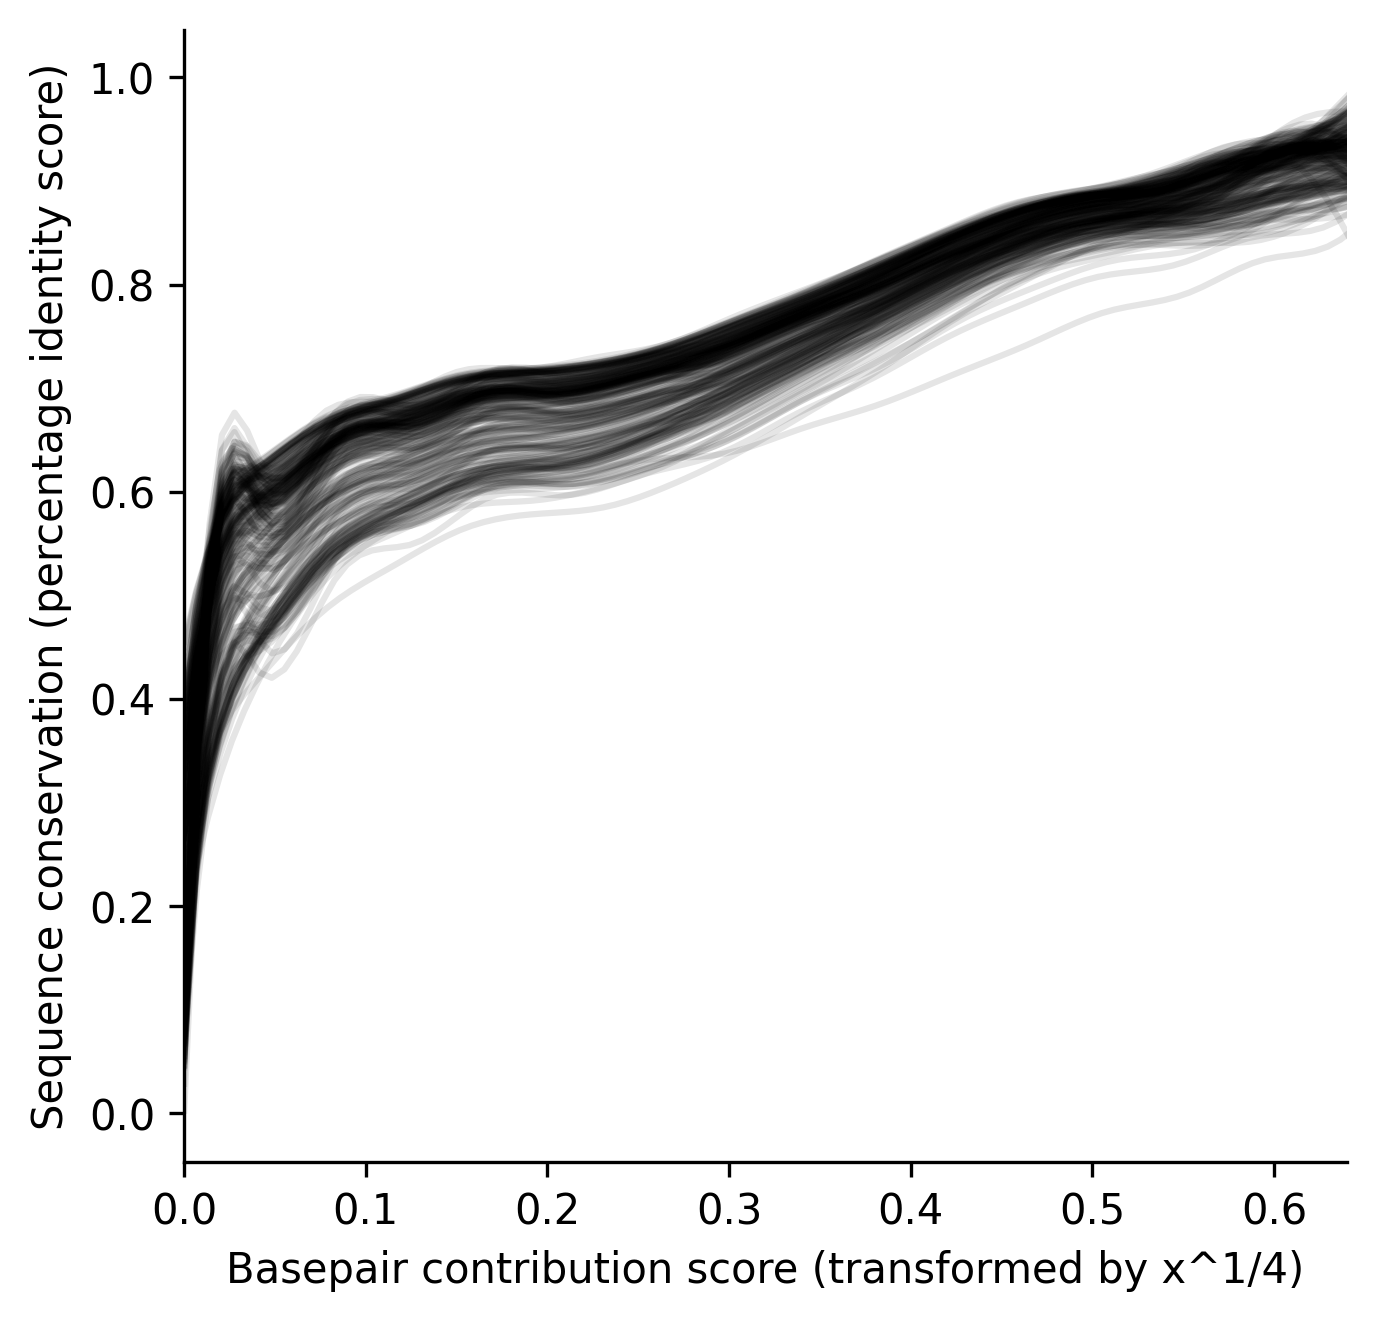

In [ ]:
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(5,5),dpi=300)
for i in range(len(gams)):
    plt.plot( gams[i].generate_X_grid(term=0), 
             gams[i].predict(gams[0].generate_X_grid(term=0)), alpha=0.1, color='black')
seaborn.despine()


plt.xlabel('Basepair contribution score (transformed by x^1/4)')
plt.ylabel('Sequence conservation (percentage identity score)')
plt.xlim(0,0.64)
plt.savefig('./figures/evolution_contri_conservation.gam.pdf')

In [ ]:
import pyBigWig
bw = pyBigWig.open("./resources/cactus241way.phyloP.bw") 

evoscores = []
for tssi in range(40000):
    offset = 1 if tsses['strand'][tssi] == '-' else 0
    score = bw.values(tsses['chr'][tssi], tsses['TSS'][tssi]-500+offset, tsses['TSS'][tssi]+500+offset, numpy=True)
    if tsses['strand'][tssi] == '-':
        score = score[::-1]
    evoscores.append(score)
    
evoscores = np.array(evoscores)
evoscores[np.isnan(evoscores)]=0

In [ ]:
motifact_seqs = h5py.File('./data/evo_motifact_seqs.h5', 'r')['/data'][:,41,:,:]
motifact_species = h5py.File('./data/evo_motifact_seqs.h5', 'r')['/data']

In [ ]:
evoscores = np.load('./data/evoscores.npy')

In [ ]:
from pygam import GAM, s, te
data = np.abs(seqcontri_species[:,41,0,:])
gam = GAM(s(0)).fit(((data/data.sum(axis=1, keepdims=True))**0.25).flatten()[mask], 
                    evoscores.flatten()[mask])


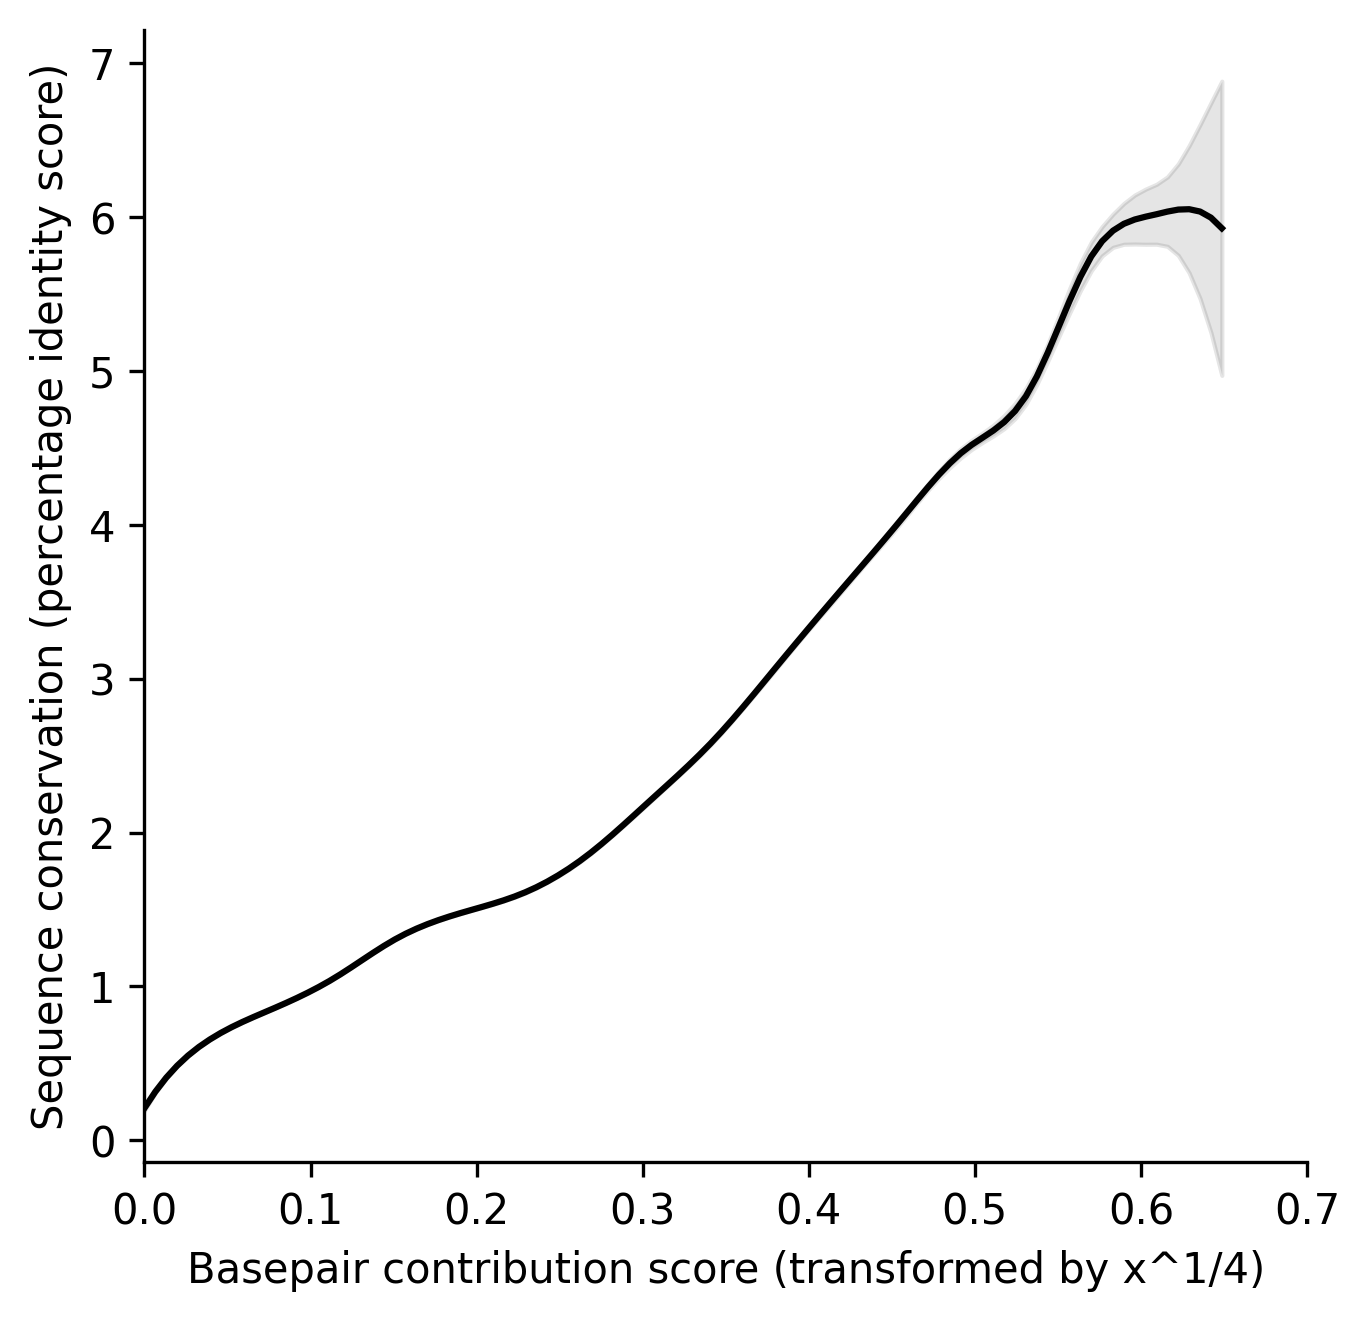

In [ ]:
import seaborn
plt.figure(figsize=(5,5),dpi=300)
plt.plot( gam.generate_X_grid(term=0), 
         gam.predict(gams[0].generate_X_grid(term=0)), alpha=1, color='black')
ci = gam.confidence_intervals(gams[0].generate_X_grid(term=0), width=0.95, quantiles=None)

plt.fill_between(gam.generate_X_grid(term=0)[:,0], ci[:,0], ci[:,1],color='black',alpha=0.1)
seaborn.despine()

plt.xlabel('Basepair contribution score (transformed by x^1/4)')
plt.ylabel('Sequence conservation (percentage identity score)')
plt.xlim(0,0.7)
plt.savefig('./figures/evolution_contri_phylop.gam.pdf')

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R 
require(scales)
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(1, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}
scale_fill_Publication <- function(...){
      discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}
scale_colour_Publication <- function(...){
      discrete_scale("colour","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

R[write to console]: Loading required package: scales



In [ ]:
x = (data/data.sum(axis=1, keepdims=True)).flatten()
y = evoscores.flatten()

R[write to console]: Loading required package: ggplot2

R[write to console]: Saving 4 x 4 in image

R[write to console]: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

R[write to console]: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



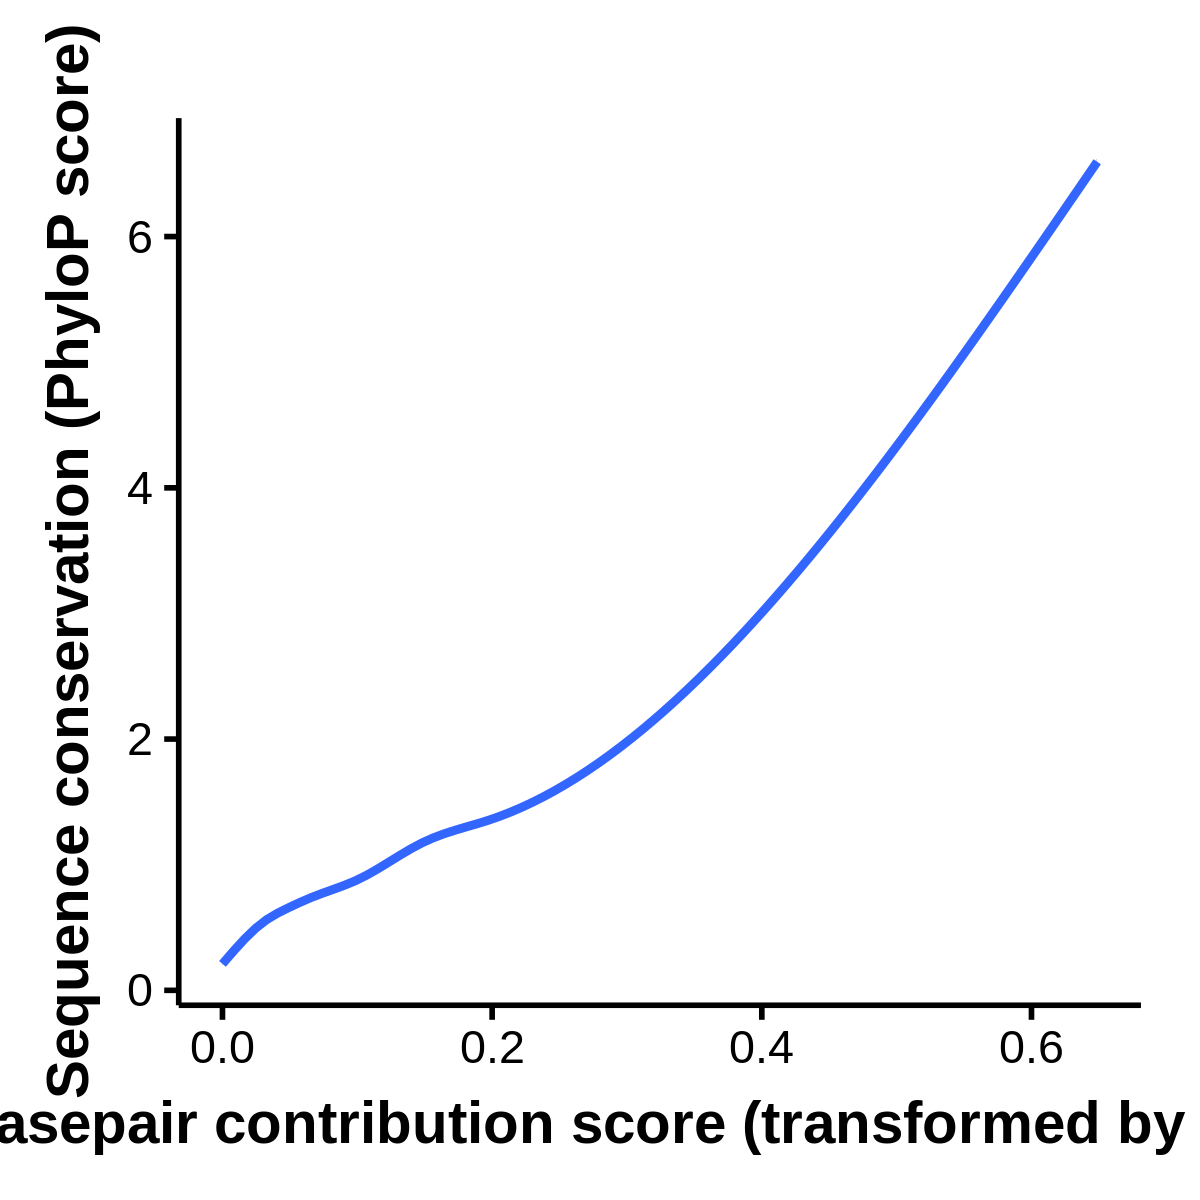

In [ ]:
%%R -i x,y -w 4 -h 4 --unit in --res 300
require(ggplot2)
p= ggplot()+geom_smooth(aes(x=x**0.25, y=y))+theme_Publication()+xlab('Basepair contribution score (transformed by x^1/4)')+
  ylab('Sequence conservation (PhyloP score)')
ggsave('./figures/evolution_contri_phylop.gam.ggplot.pdf', device=cairo_pdf)
p

In [ ]:


motifnames_original=  ['SP -', 'ETS -', 'CREB -', 'NFY -', 'YY1 -', 'U1 snRNP +', 'Long Inr +', 'NRF1 +', 'ZNF143 -', 'TATA -',
                      'SP +', 'ETS +', 'CREB +', 'NFY +', 'YY1 +', 'U1 snRNP -', 'Long Inr -', 'NRF1 -', 'ZNF143 +', 'TATA +']



ExpSineSquared(length_scale=5.04, periodicity=10.4) * RBF(length_scale=114) + WhiteKernel(noise_level=0.149)
ExpSineSquared(length_scale=4.51, periodicity=10.2) * RBF(length_scale=60.7) + WhiteKernel(noise_level=0.0966)


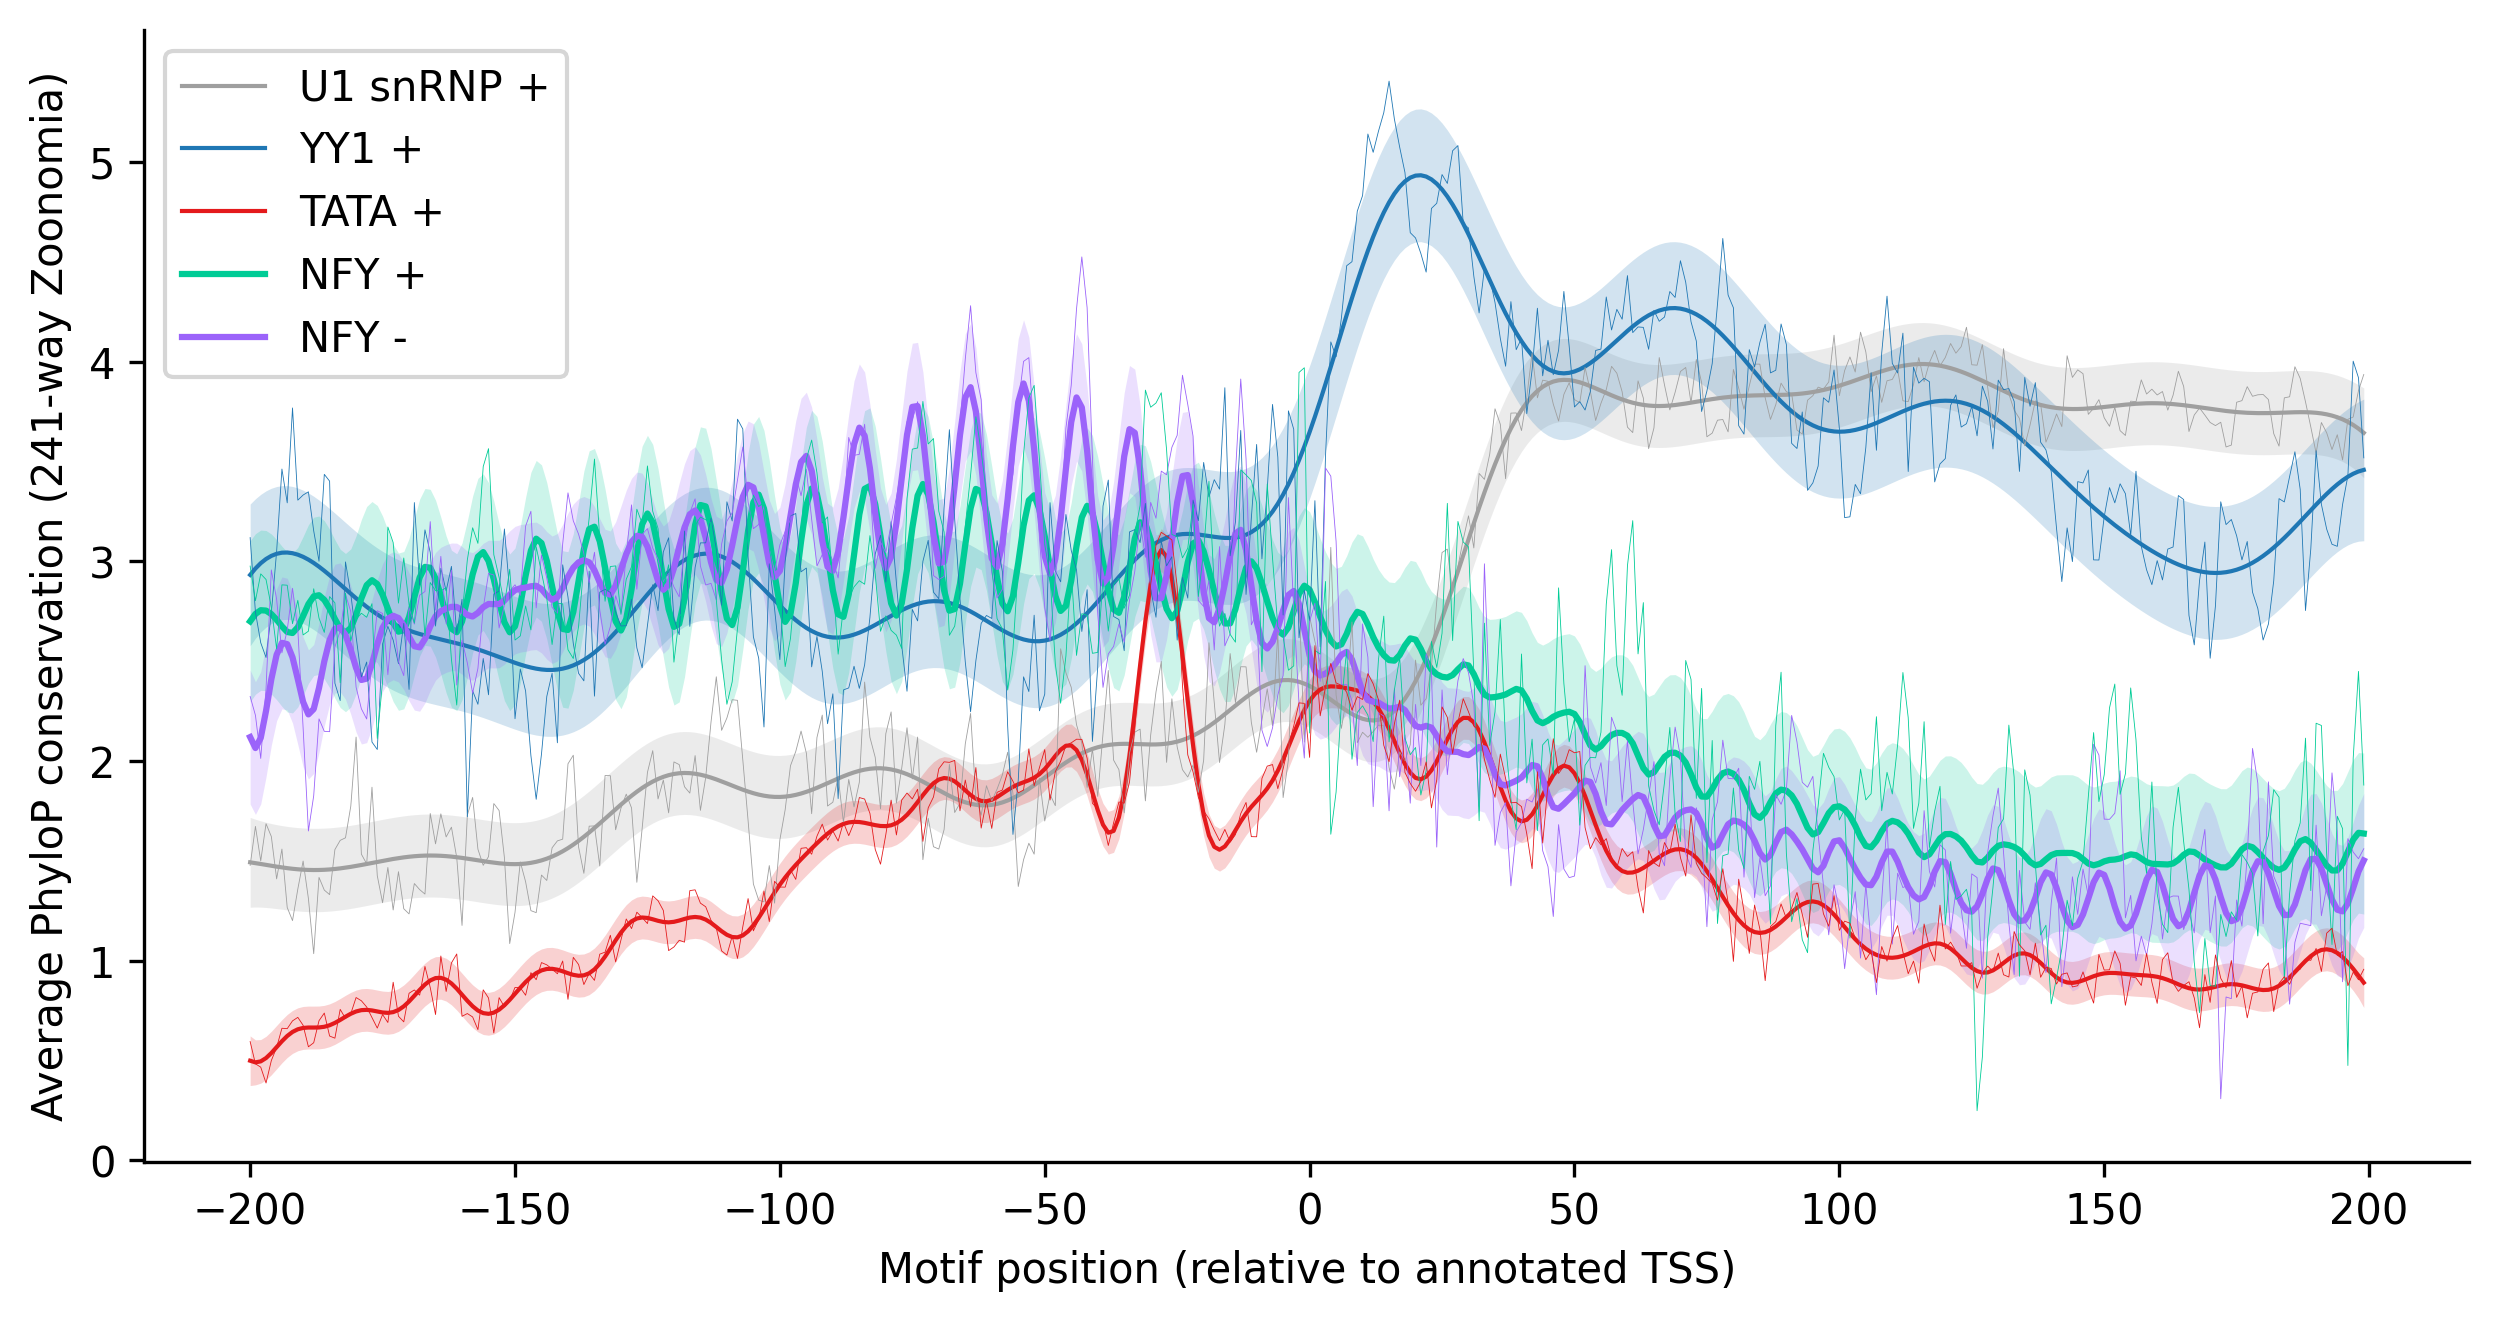

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
import seaborn as sns

plt.figure(dpi=300,figsize=(10,5))
seaborn.set_palette("Set1",6)
halfwindow = 200

colordict = {'YY1 +': '#1F77B4',
'YY1 -': '#c2d5e8',
'TATA +': '#E41A1C',
'TATA -': '#ffc6ba',
'U1 snRNP +': '#9F9F9F',
'U1 snRNP -': '#CFCFCF',
'NFY +': '#00CC96',
'NFY -': '#9B63FA',
'ETS +': '#19d3f3',
'ETS -': '#19e4f3',
'SP +': '#FF7F0E',
'SP -': '#ff930e',
'NRF1 +': '#AB63FA',
'NRF1 -': '#b663fa',
'ZNF143 +': '#17a4cf',
'ZNF143 -': '#17BECF',
'CREB +': '#FF6692',
'CREB -': '#ff66c2',
'Long Inr +': '#95a2be',
'Long Inr -': '#dde1ea'}

for m in ['U1 snRNP +','YY1 +', 'TATA +']:
    x=np.arange(-halfwindow,halfwindow)
    y=(np.clip(motifact_seqs[:,motifnames_original.index(m),500-halfwindow:500+halfwindow],0,np.inf) * (evoscores[:,500-halfwindow:500+halfwindow])).sum(axis=0) / np.clip(motifact_seqs[:,motifnames_original.index(m),500-halfwindow:500+halfwindow],0,np.inf).sum(axis=0)
    gp = GaussianProcessRegressor(   RBF(length_scale=5)+ WhiteKernel(0.1)).fit(x[:,None],y)
    mean_predictions_gpr, std_predictions_gpr = gp.predict(
        x[:,None],
        return_std=True,
    )
    plt.plot(x, mean_predictions_gpr, linewidth=1., label=m, color=colordict[m])
    plt.fill_between(
        x,
        mean_predictions_gpr - std_predictions_gpr,
        mean_predictions_gpr + std_predictions_gpr,
        alpha=0.2,
        linewidth=0,
        color=colordict[m]
    )
    
for m in ['NFY +', 'NFY -']:
    x=np.arange(-halfwindow,halfwindow)
    y=(np.clip(motifact_seqs[:,motifnames_original.index(m),500-halfwindow:500+halfwindow],0,np.inf) * (evoscores[:,500-halfwindow:500+halfwindow])).sum(axis=0) / np.clip(motifact_seqs[:,motifnames_original.index(m),500-halfwindow:500+halfwindow],0,np.inf).sum(axis=0)
    gp = GaussianProcessRegressor(  (ExpSineSquared(length_scale=5, periodicity=10.5 )  * RBF(length_scale=100))+ WhiteKernel(0.1)).fit(x[:,None],y)
    mean_predictions_gpr, std_predictions_gpr = gp.predict(
        x[:,None],
        return_std=True,
    )
    plt.plot(x, mean_predictions_gpr, linewidth=1.5, label=m, color=colordict[m])
    plt.fill_between(
        x,
        mean_predictions_gpr - std_predictions_gpr,
        mean_predictions_gpr + std_predictions_gpr,
        alpha=0.2,
        linewidth=0,
        color=colordict[m]
    )
    print(gp.kernel_)
    
plt.gca().set_prop_cycle(None)
for m in ['U1 snRNP +', 'YY1 +','NFY -','NFY +', 'TATA +']:
    x=np.arange(-halfwindow,halfwindow)
    y=(np.clip(motifact_seqs[:,motifnames_original.index(m),500-halfwindow:500+halfwindow],0,np.inf) * (evoscores[:,500-halfwindow:500+halfwindow])).sum(axis=0) / np.clip(motifact_seqs[:,motifnames_original.index(m),500-halfwindow:500+halfwindow],0,np.inf).sum(axis=0)
    plt.plot(x, y,linewidth=0.2, color=colordict[m])
    
plt.legend()
plt.xlabel('Motif position (relative to annotated TSS)')
plt.ylabel('Average PhyloP conservation (241-way Zoonomia)')
sns.despine()
plt.savefig('./figures/evolution_motif_conservation.gp.pdf')

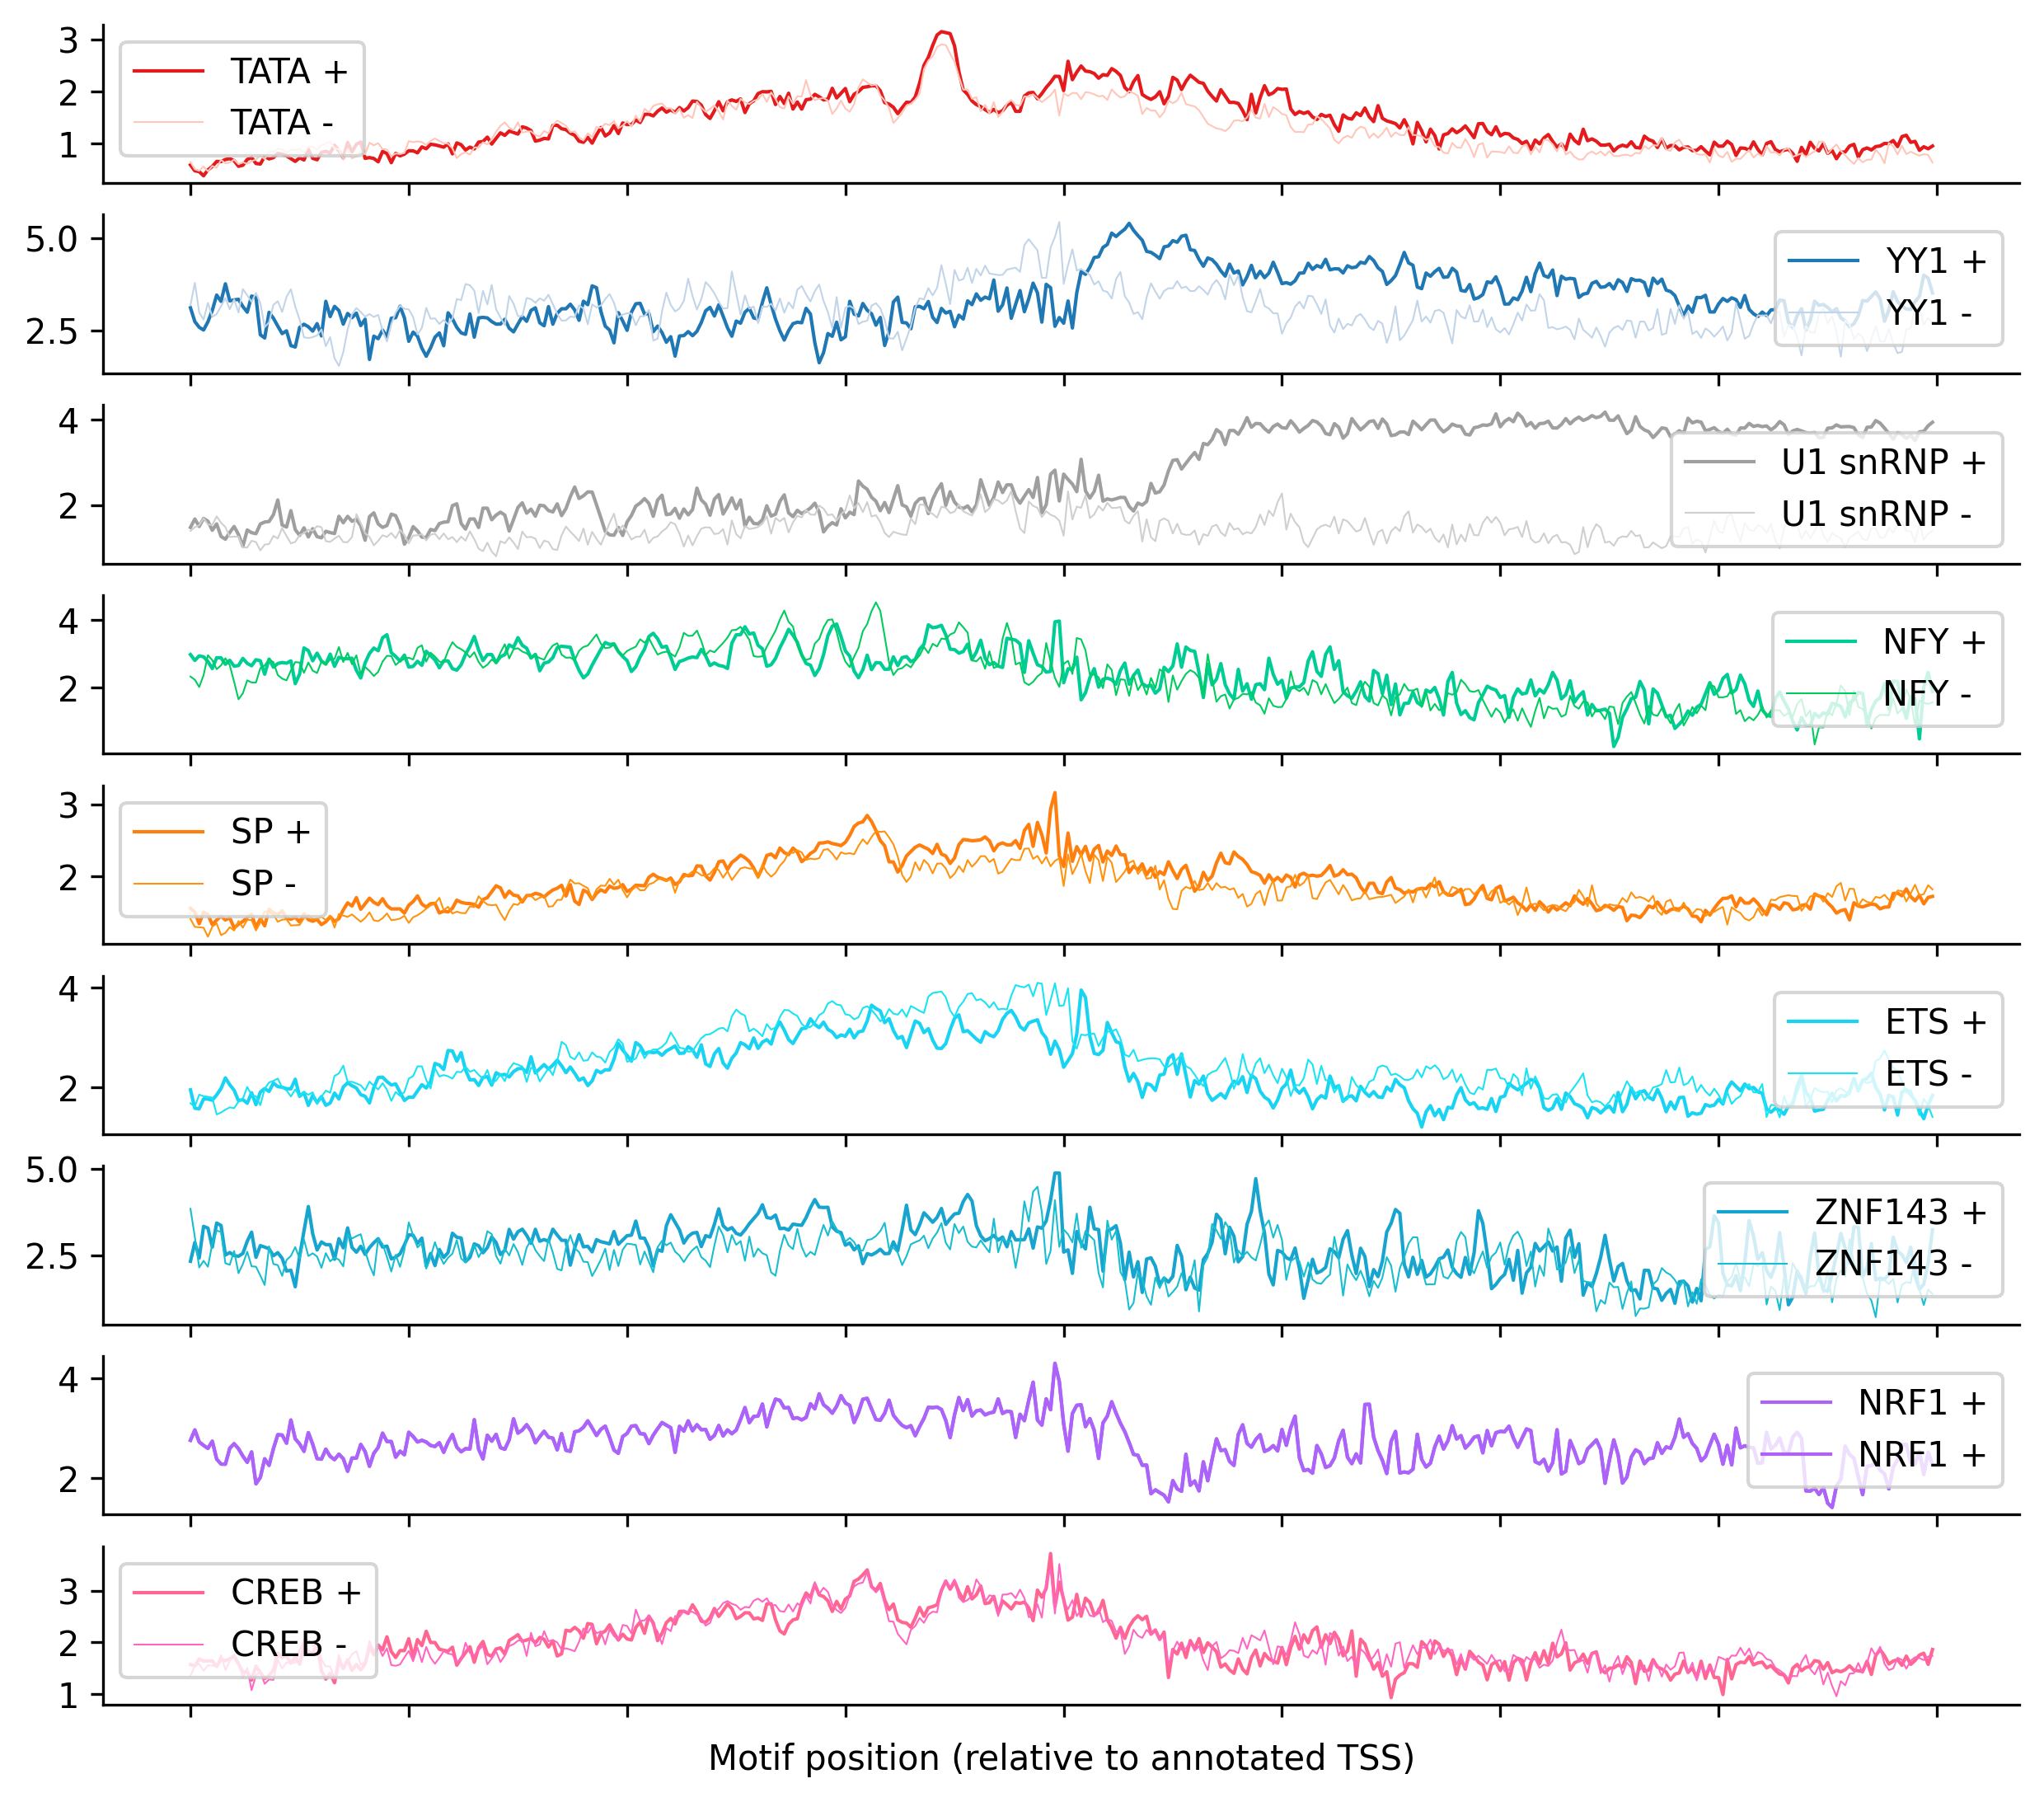

In [ ]:
import seaborn
halfwindow=200
colordict = {'YY1 +': '#1F77B4',
    'YY1 -': '#c2d5e8',
    'TATA +': '#E41A1C',
    'TATA -': '#ffc6ba',
    'U1 snRNP +': '#9F9F9F',
    'U1 snRNP -': '#CFCFCF',
    'NFY +': '#00CC96',
    'NFY -': '#00cc5f',
    'ETS +': '#19d3f3',
    'ETS -': '#19e4f3',
    'SP +': '#FF7F0E',
    'SP -': '#ff930e',
    'NRF1 +': '#AB63FA',
    'NRF1 -': '#b663fa',
    'ZNF143 +': '#17a4cf',
    'ZNF143 -': '#17BECF',
    'CREB +': '#FF6692',
    'CREB -': '#ff66c2',
    'Long Inr +': '#95a2be',
    'Long Inr -': '#dde1ea'}
    
_, axes = plt.subplots(nrows=len(motifnames_original)//2-1, dpi=300,figsize=(10,len(motifnames_original)//2-1))

i=0
for m in ['TATA +', 'TATA -', 'YY1 +', 'YY1 -', 'U1 snRNP +', 'U1 snRNP -', \
 'NFY +', 'NFY -', 'SP +', 'SP -', 'ETS +', 'ETS -', 'ZNF143 +', 'ZNF143 -', 'NRF1 +', 'NRF1 +','CREB +', 'CREB -']:
    if 'Long Inr' not in m: 
        x=np.arange(-halfwindow,halfwindow)
        y=(np.clip(motifact_seqs[:,motifnames_original.index(m),500-halfwindow:500+halfwindow],0,np.inf) * (evoscores[:,500-halfwindow:500+halfwindow])).sum(axis=0) / np.clip(motifact_seqs[:,motifnames_original.index(m),500-halfwindow:500+halfwindow],0,np.inf).sum(axis=0)
        axes[i//2].plot(x, y, linewidth=0.5 if '-' in m else 1, color=colordict[m], label=m)
        axes[i//2].legend()
        seaborn.despine()
        if i < len(motifnames_original):
            axes[i//2].set_xticklabels([])
        i+=1
plt.xlabel('Motif position (relative to annotated TSS)')

plt.savefig('./figures/evolution_motif_conservation.all.pdf')

In [ ]:
evo_bydist_species = []
halfwindow=200
for i in range(241):
    print(i)
    motifact_species_one = motifact_species[:,i,:,:]
    seq_identity_mean = identities_withgap_all[:,i,:]
    evo_bydist=np.nanmean((np.clip(motifact_species_one[:,:,500-halfwindow:500+halfwindow],0,np.inf) * \
              (seq_identity_mean[:,None,500-halfwindow:500+halfwindow])),axis=0) / np.nanmean(np.clip(motifact_species_one[:,:,500-halfwindow:500+halfwindow],0,np.inf), axis=0)
    evo_bydist_species.append(evo_bydist)
evo_bydist_species = np.array(evo_bydist_species)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155


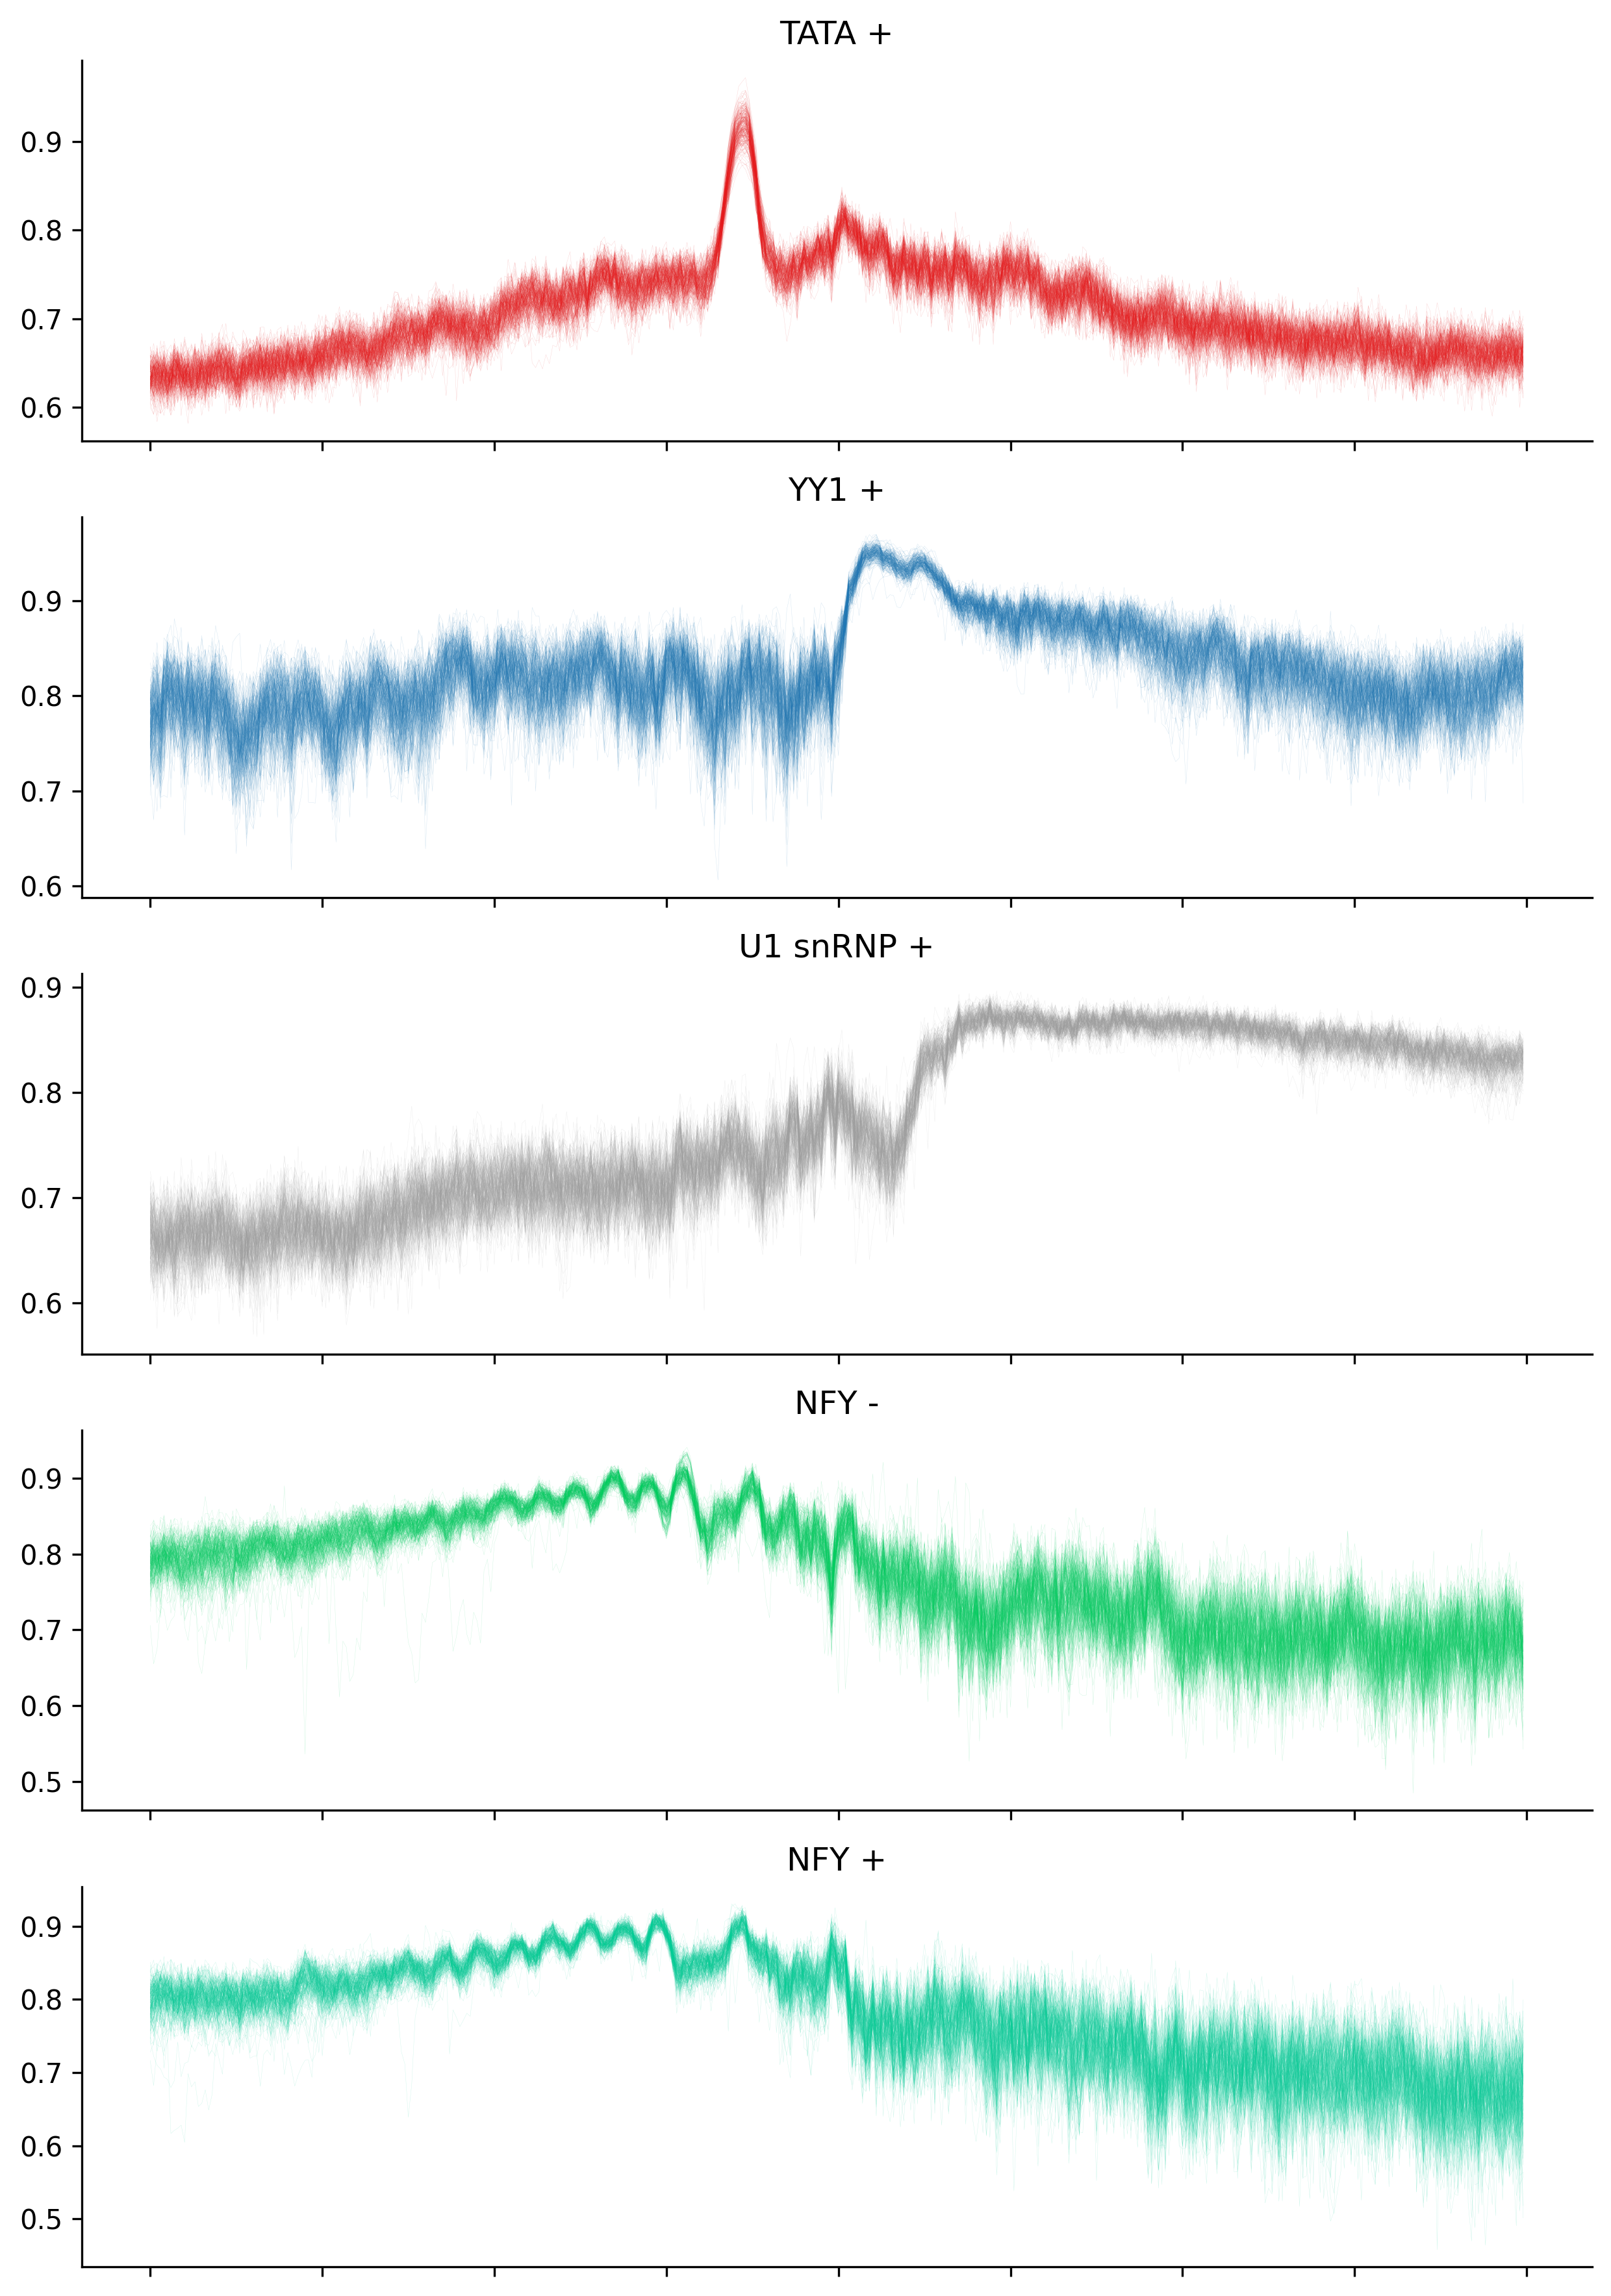

In [ ]:
def quantile_normalize(x):
    lower, upper =  np.quantile(x,[0.1,0.9], axis=[2])
    return (x - lower[...,None])/(upper-lower)[...,None]*(upper-lower)[...,None].mean(axis=0)[None,...]+lower[...,None].mean(axis=0)[None,...]

_, axes = plt.subplots(nrows=5, dpi=300,figsize=(10,15))

for  ax, m in zip(axes, [ 'TATA +','YY1 +', 'U1 snRNP +', 'NFY -','NFY +',]):
    ax.plot(quantile_normalize(np.array(evo_bydist_species))[:,motifnames_original.index(m),:].T, 
            c=colordict[m], linewidth=0.1,alpha=0.2)
    ax.set_title(m)
    seaborn.despine()
    
    if m!='NFY+':
        ax.set_xticklabels([])

plt.savefig('./figures/evolution_motif_conservation.allspecies.pdf')